In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
from scipy import interpolate
import astropy.stats as astro_stats
from scipy.optimize import curve_fit
from astropy.io import ascii
from scipy.signal import find_peaks
import scipy.integrate as integrate
from scipy.signal import savgol_filter

In [8]:
lc = ascii.read("https://ztf.snad.space/dr17/csv/802211300046586")

In [9]:
x, y, z = lc['mjd'], lc['mag'], lc['magerr']

In [12]:
def deviation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)


def variation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag_err), astro_stats.biweight_scale(mag_err)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)    


def calc_dip_edges(xx, yy, _cent, atol=0.2):
    """Crude estimation of the edges of a dipper given the centroid. 
    
      Parameters
      ----------
      xx (array-like): time axis
      yy (array-like): dev
      _cent (float): centroid time 
      atol (float): tolerance to the median. Default is 0.2
    """
    
    indices_forward = np.where((xx > _cent) & np.isclose(yy, np.median(yy) - 0.011*np.median(yy), atol=atol))[0]
    t_forward = xx[indices_forward[0]] if indices_forward.size > 0 else 0
    
    indices_back = np.where((xx < _cent) & np.isclose(yy, np.median(yy) - 0.011*np.median(yy), atol=atol))[0]
    if indices_back.size > 0:
        t_back = xx[indices_back[-1]]
    else:
        t_back = 0
        
    # Diagnostics numbers
    
    # How many detections above the median thresh in the given window?
    _window_ = (xx>t_back) & (xx<t_forward)
    sel_1_sig = (yy[_window_]>np.median(yy) + 1*np.std(yy)) # detections above 1 sigma
    N_thresh_1 = len((yy[_window_])[sel_1_sig])
    
    return t_forward, t_back, (t_forward-_cent), N_thresh_1


def summarize_dev_dips(times, dips, power_thresh=3, loc_peak_thresh=6, peak_close_rmv=15):
    
    yht = savgol_filter(dips, 11, 8) # try savgol smoothing...
    
    # Scipy peak finding algorithm
    pks, _ = find_peaks(yht, height=loc_peak_thresh, distance=500)

    pks = np.sort(pks)[::-1] # sort the reverse peaks
    
    # Time of peaks and dev of peaks
    t_pks, p_pks = times[pks], dips[pks]
    
    if len(pks)>1:
        # remove peaks that are too close to each other
        t_pks = np.array([t_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                             t_pks[i+1],
                                                                             atol=peak_close_rmv)]) # 5 day tolerance window...

        p_pks = np.array([p_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                            t_pks[i+1],
                                                                            atol=peak_close_rmv)])
        srt = np.argsort(t_pks) # argsort the t_pks

        t_pks, p_pks = t_pks[srt], p_pks[srt] # rename variables...
    
    N_peaks = len(t_pks) # number of peaks with removed
    
    # summarize peak information
    dip_summary = {}
    
    i = 0
    for time_ppk, ppk in zip(t_pks, p_pks):
        _edges = calc_dip_edges(times, dips, time_ppk, atol=0.2)
        
        dip_summary[f'dip_{i}'] = {
            "peak_loc": time_ppk,
            'window_start': _edges[0],
            'window_end': _edges[1],
            "N_1sig_in_dip": _edges[-1], 
            'loc_forward_dur': _edges[2],
            "dip_power":ppk
        }
        
        i+=1
    
    return N_peaks, dip_summary

In [14]:
dev = deviation(y, z)

(18.814168784499998, 17.8686755655)

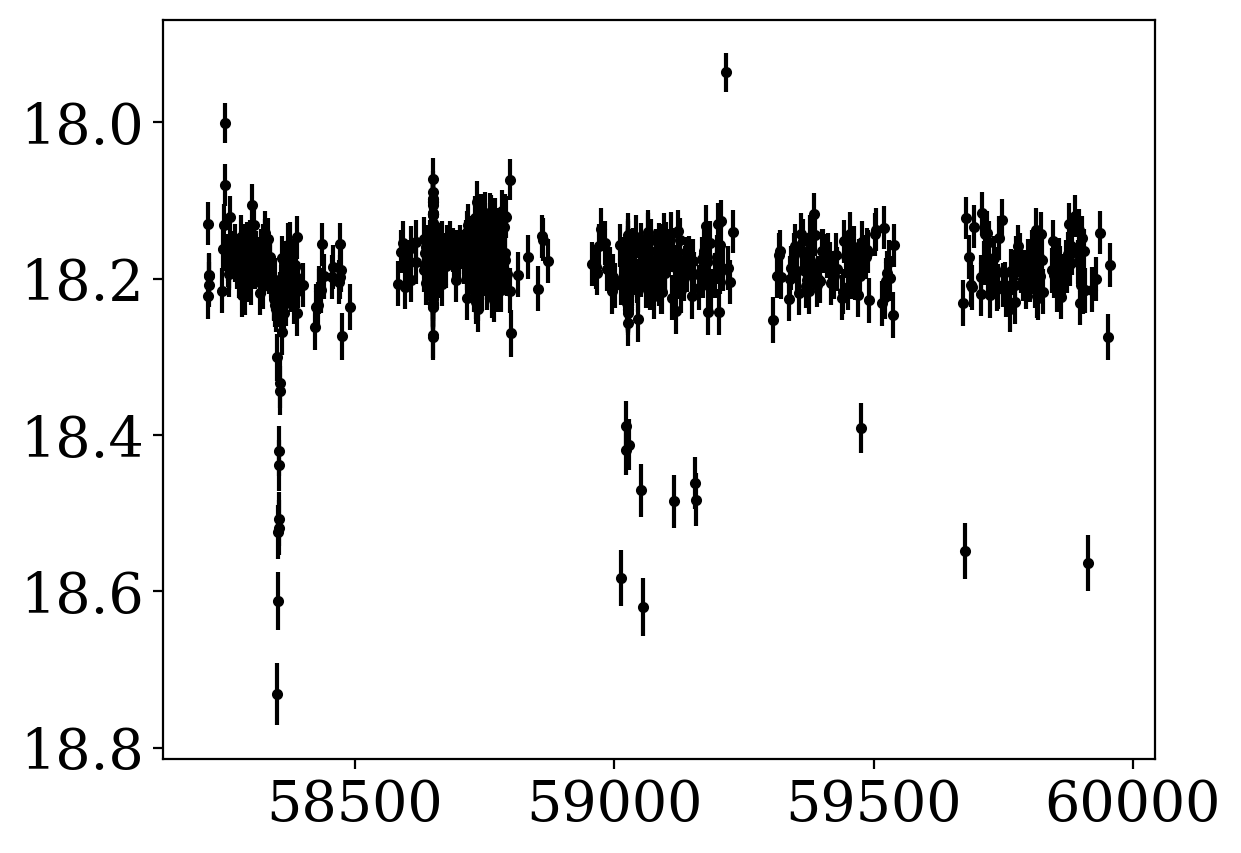

In [15]:
plt.errorbar(x, y, z, fmt='.', color='k')
plt.ylim(plt.ylim()[::-1])

In [18]:
summarize_dev_dips(x, dev)[1]['dip_0']

{'peak_loc': 58351.36639,
 'window_start': 58364.30654,
 'window_end': 58337.33468,
 'N_1sig_in_dip': 13,
 'loc_forward_dur': 12.940149999994901,
 'dip_power': 8.918009677170696}

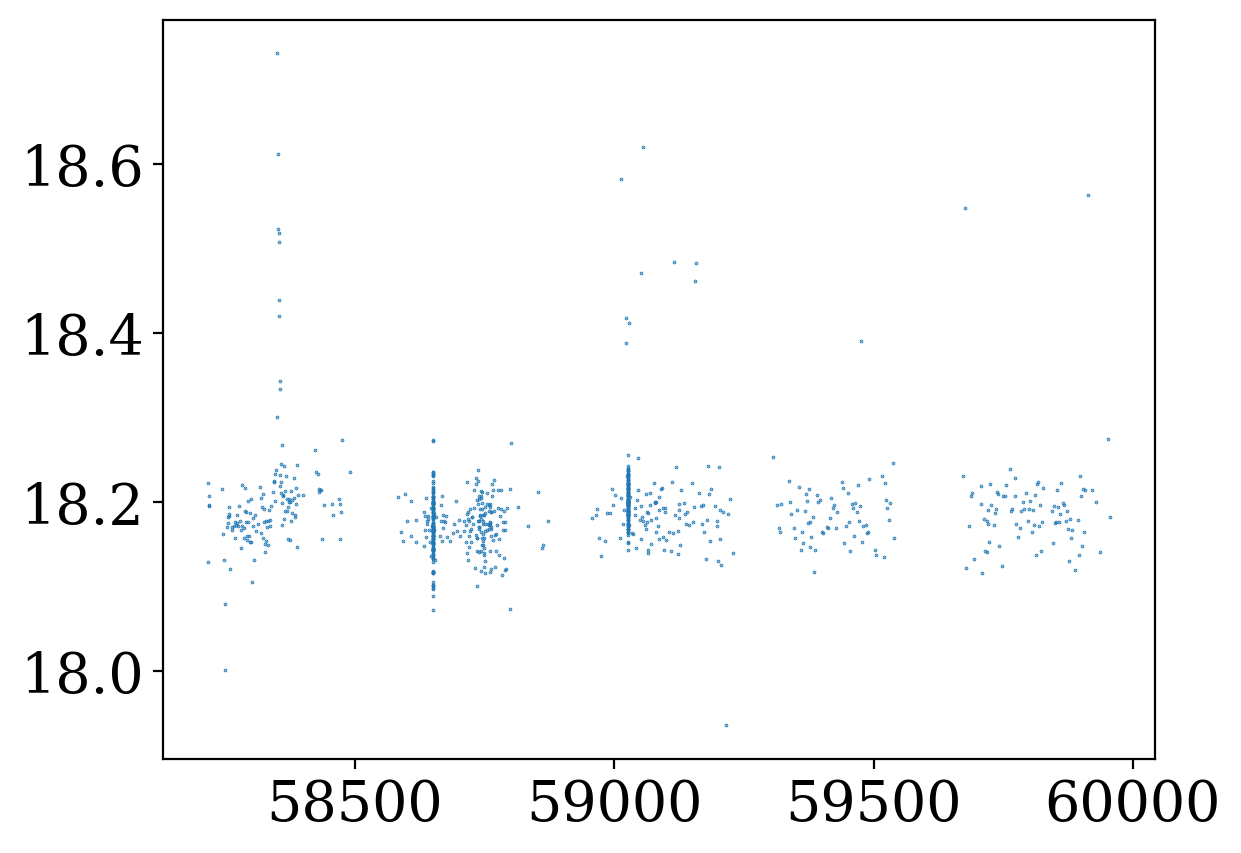

In [58]:
plt.scatter(x, y, s=0.1)

In [332]:
def calc_dip_edges(xx, yy, _cent, atol=0.01):
    """ Calculate the edges of a dip given the center dip time. 

    Parameters:
    -----------
    xx (array-like): Time values of the light curve.
    yy (array-like): Magnitude values of the light curve.
    _cent (float): Center time of the dip.
    atol (float): Tolerance for the edge calculation. Default is 0.2.

    Returns:
    --------
    t_forward (float): Forward edge of the dip.
    t_back (float): Backward edge of the dip.
    time forward difference (float): Time difference between the forward edge and the center.
    time backward difference (float): Time difference between the backward edge and the center.
    N_thresh_1 (int): Number of detections above the median threshold in the given window.
    t_in_window (float): Average time difference in the given window.
    """
    indices_forward = np.where((xx > _cent) & np.isclose(yy, np.mean(yy) - 0.7*np.std(yy), atol=atol))[0]
    t_forward = xx[indices_forward[0]] if indices_forward.size > 0 else 0
    
    # select indicies close to the center (negative)
    indices_back = np.where((xx < _cent) & np.isclose(yy, np.mean(yy) - 0.7*np.std(yy), atol=atol))[0]
    if indices_back.size > 0:
        t_back = xx[indices_back[-1]]
    else:
        t_back = 0
        
    # Diagnostics numbers
    # How many detections above the median thresh in the given window?
    _window_ = (xx>t_back) & (xx<t_forward)
    sel_1_sig = (yy[_window_]>np.median(yy) + 1*np.std(yy)) # detections above 1 sigma
    N_thresh_1 = len((yy[_window_])[sel_1_sig])
    N_in_dip = len((yy[_window_]))

    # select times inside window and compute the average distance
    t_in_window = np.nanmean(np.diff(xx[_window_]))

    return t_forward, t_back, t_forward-_cent, _cent-t_back, N_thresh_1, N_in_dip, t_in_window

In [333]:
delids = np.random.randint(32, 95, 40)

In [334]:
xx, yy = np.delete(x, delids), np.delete(y, delids)

In [335]:
edge2 = calc_dip_edges(xx, yy, 58351.36639, atol=0.01)

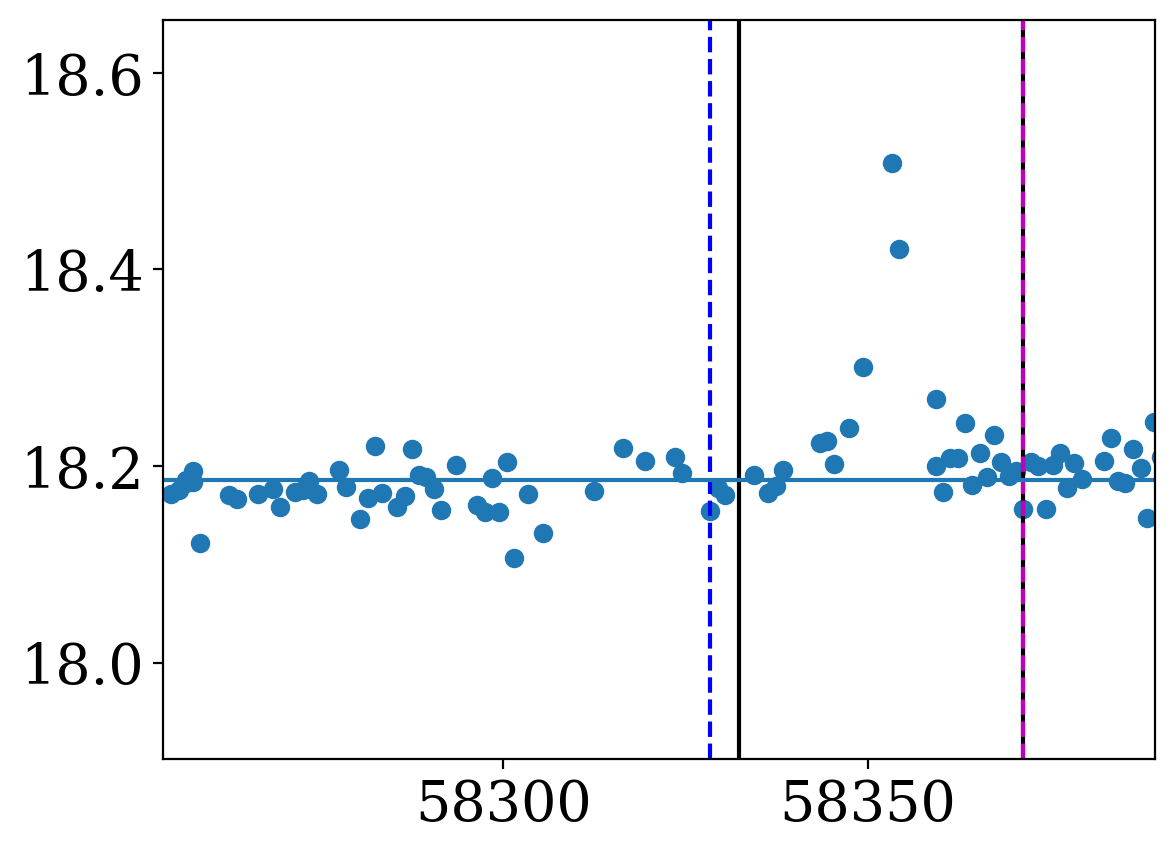

In [336]:
#plt.scatter(x, y)
plt.scatter(xx, yy)


plt.axvline(edge[0], color='k')
plt.axvline(edge[1], color='k')

plt.axvline(edge2[0], color='m', ls='--')
plt.axvline(edge2[1], color='blue', ls='--')

plt.xlim(58351.36639-98, 58351.36639+38)
plt.axhline(np.median(y))

# TODO: needs more fixing...